# Explorando os dados

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.features import (
    JointPlotVisualizer,
    Rank2D,
    RadViz,
    ParallelCoordinates)
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,
    preprocessing,
    tree,
)

In [20]:
url = ("https://hbiostat.org/data/repo/titanic3.csv")
df = pd.read_csv(url)
org_df = df

In [21]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(org_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


## Tamanho dos dados

O tamanho dos dados pode ser obtido de diversas formas. A mais simples é através da propriedade `shape` do `DataFrame`.

In [22]:
X.shape

(1309, 8)

1309 linhas e 8 colunas.

Uma forma alternativa seria através do método `info()`.

Este metodo retorna o tamanho dos dados e também o tipo de cada coluna.

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1214 to 513
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   float64
 1   age         1309 non-null   float64
 2   sibsp       1309 non-null   float64
 3   parch       1309 non-null   float64
 4   fare        1309 non-null   float64
 5   sex_male    1309 non-null   uint8  
 6   embarked_Q  1309 non-null   uint8  
 7   embarked_S  1309 non-null   uint8  
dtypes: float64(5), uint8(3)
memory usage: 65.2 KB


Utilizando o método `describe()` é possível obter algumas estatísticas descritivas dos dados.

- `count`: quantidade de valores válidos - não nulos

- `mean`: média dos valores

- `std`: desvio padrão

- `min`: valor mínimo

- `25%`: primeiro quartil

- `50%`: segundo quartil ou mediana

- `75%`: terceiro quartil

- `max`: valor máximo

In [24]:
X.describe()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,-0.012831,0.052084,-0.037396,0.385027,-0.007599,0.644003,0.093965,0.698243
std,0.995822,1.038466,0.963074,0.865560,0.980143,0.478997,0.291891,0.459196
min,-1.551881,-2.220991,-0.498616,0.000000,-0.704308,0.000000,0.000000,0.000000
25%,-0.363317,-0.517409,-0.498616,0.000000,-0.488146,0.000000,0.000000,0.000000
50%,0.825248,-0.166237,-0.498616,0.000000,-0.363928,1.000000,0.000000,1.000000
75%,0.825248,0.575131,0.425943,0.000000,-0.045335,1.000000,0.000000,1.000000
max,0.825248,4.008828,6.897852,9.000000,9.066014,1.000000,1.000000,1.000000


Utilizando o atributo `iloc` é possível acessar os dados de uma linha específica. Juntando ele ao `describe()` é possível obter as estatísticas descritivas de uma linha específica. Neste caso, busca-se a primeira e a última linha

Com este atributo é possível selecionar linhas e colunas específicas com base na posição de um índice. Para o `iloc` o índice é numérico.

O atributo `loc` é similar ao `iloc`, porém o índice é o valor do índice e não a posição. No caso dos DataFrames, o índice é nome da posição.

In [25]:
X.describe().iloc[:, [0,-1]]

,pclass,embarked_S
count,1309.000000,1309.000000
mean,-0.012831,0.698243
std,0.995822,0.459196
min,-1.551881,0.000000
25%,-0.363317,0.000000
50%,0.825248,1.000000
75%,0.825248,1.000000
max,0.825248,1.000000


## Histogramas

Histogramas são gráficos que permitem visualizar a distribuição dos dados. São bem simples de serem gerados, basta utilizar `.plot(kind='hist')` no DataFrame, utilizando o `matplotlib` como backend.

Os valores devem ser numéricos para que o histograma seja gerado.

<Axes: ylabel='Frequency'>

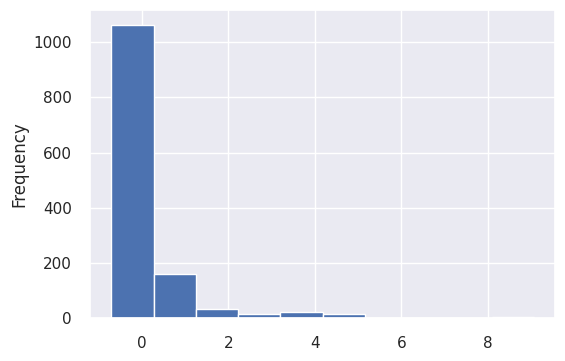

In [26]:
fig, ax = plt.subplots(figsize=(6,4))

X.fare.plot(kind='hist', ax=ax)

Utlizando `seaborn` é possível gerar histogramas com mais facilidade. Basta utilizar `sns.distplot()`. Este método já gera o histograma e também a curva de densidade.

<ipython-input-27-17864340a7d0>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(X_train[mask].fare, label="Survived")
<ipython-input-27-17864340a7d0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(X_train[~mask].fare, label="Died")


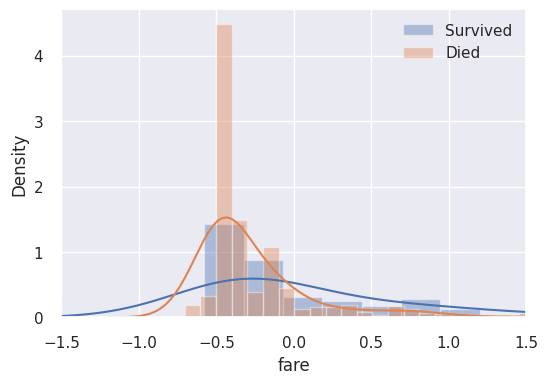

In [27]:
fig, ax = plt.subplots(figsize=(6,4))
mask = y_train == 1

ax = sns.distplot(X_train[mask].fare, label="Survived")
ax = sns.distplot(X_train[~mask].fare, label="Died")

ax.set_xlim(-1.5, 1.5)
ax.legend()

## Scatterplots

Scatterplots são gráficos que permitem visualizar a relação entre duas variáveis. São bem simples de serem gerados, basta utilizar `.plot.scatter(x='coluna1', y='coluna2')` no DataFrame, utilizando o `matplotlib` como backend.

Ajuste os valores de `c` e `colormap` para obter um gráfico mais informativo.

O paràmetro `alpha` ajusta a transparência dos pontos.

Além disso os Scatterplots são extremamente úteis para identificar outliers.

<Axes: xlabel='age', ylabel='fare'>

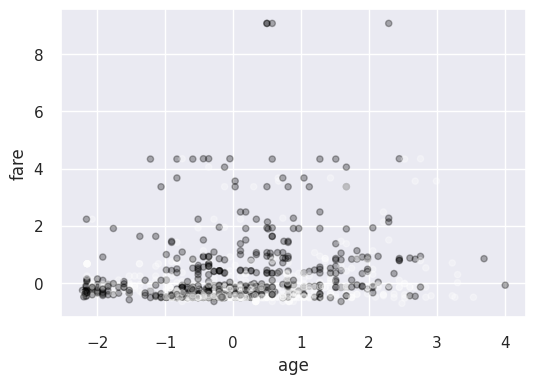

In [28]:
fig, ax = plt.subplots(figsize=(6,4))

X.plot.scatter(
    x="age", y="fare",c=y, ax=ax, alpha=0.3 # Ajuste o alpha se houver sobreposição de pontos
)


Não aparenta haver uma relação entre as variáveis, poia os pontos estão bem espalhados.

É possível utilizar a correlação de Pearson para verificar se há uma relação entre as variáveis. Para isso, basta utilizar o método `corr()` do DataFrame.  O valor retornado varia entre -1 e 1. Quanto mais próximo de 1, maior a correlação positiva. Quanto mais próximo de -1, maior a correlação negativa. Quanto mais próximo de 0, menor a correlação.

In [29]:
X.age.corr(X.fare)

0.17720039845406155

## Gráfico Conjunto (Jointplot)

É um gráfico de dispersão com histogramas nas margens. Utlizando `JointPlotVisualization` do `yellowbrick` é possível gerar este gráfico.
Combinando essa biblioteca com o `seaborn` é possível gerar uma reta de regressão através do metodo `regplot()`.

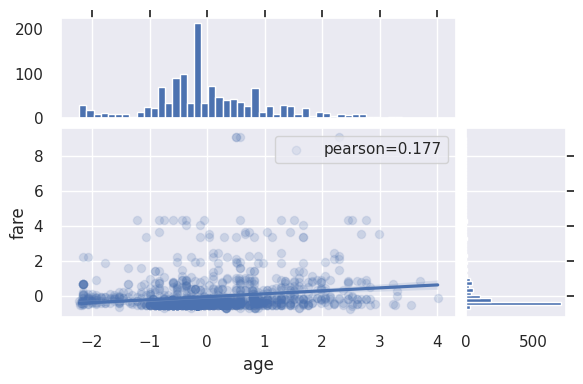

<Axes: xlabel='age', ylabel='fare'>

In [30]:
fig, ax = plt.subplots(figsize=(6,4))
jpv = JointPlotVisualizer(
    feature="age", target="fare",kind="scatter", alpha=0.1
)
jpv.fit(X.age, X.fare)

sns.regplot(x=X.age, y=X.fare, ax=ax, scatter_kws={"alpha": 0.1})
jpv.show()


É possível gerar o mesmo gráfico utilizando apenas o `seaborn` com o método `jointplot()`.

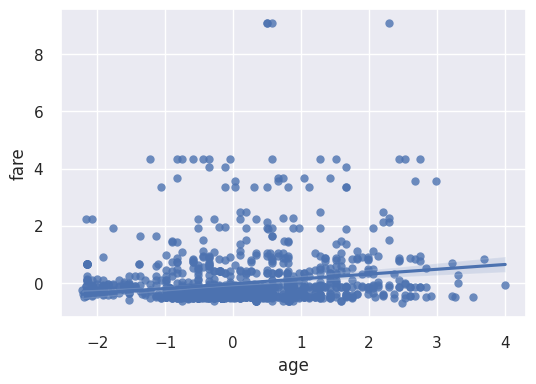

In [31]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(6, 4))

new_df = X.copy()
new_df["target"] = y

p = sns.regplot(x="age", y="fare", data=new_df, ax=ax)

plt.show()

## Matriz de Pares (pair grid)

É um gráfico que contém umz matriz de colunas e estimativas de densidade. Para colorir os pontos, é possível utilizar o parâmetro `hue`, esse parâmetro permite colorir os pontos de acordo com uma coluna específica.

Utliza-se a função `pairplot()` do `seaborn` para gerar este gráfico.

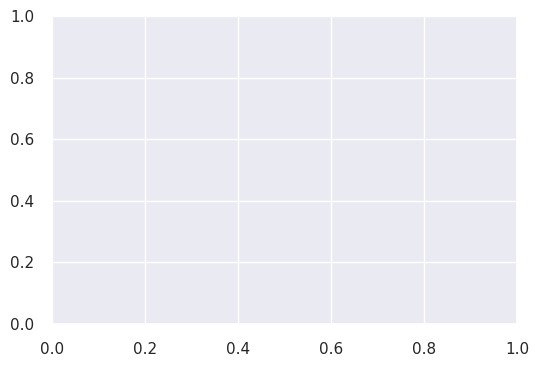

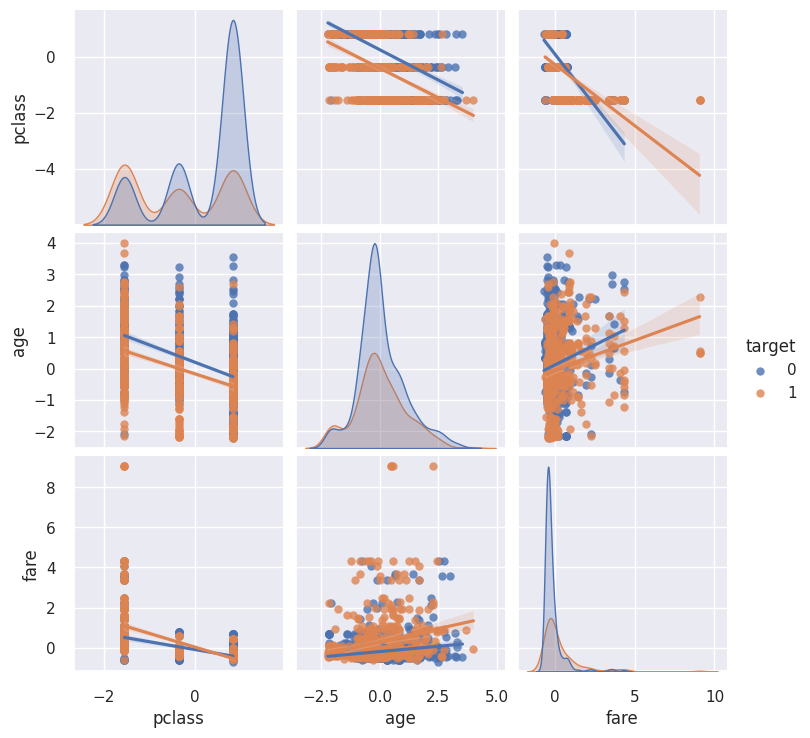

In [32]:
sns.set_theme()

# Criar uma figura e eixo do Matplotlib
fig, ax = plt.subplots(figsize=(6, 4))

# Copiar dados para um novo DataFrame
new_df = X.copy()
new_df["target"] = y

# Especificar variáveis para o pairplot
vars = ["pclass", "age", "fare"]

# Usar o mesmo eixo para o pairplot
p = sns.pairplot(new_df, vars=vars, hue="target", kind="reg")

# Exibir o gráfico
plt.show()

## Gráfico de Caixas e Gráfico de Violino

São gráficos que permitem visualizar as distribuições. O gráfico de caixa pode ser gerado usando `seaborn.boxplot()`. O gráfico de violino pode ser gerado usando `seaborn.violinplot()`. O gráfico de violino é mais informativo, pois além de mostrar a distribuição, também mostra a densidade dos dados.

<Axes: xlabel='target', ylabel='age'>

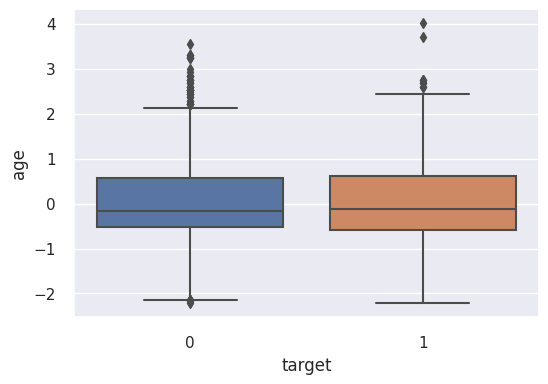

In [33]:
fig, ax = plt.subplots(figsize=(6,4))

new_df = X.copy()
new_df["target"] = y

sns.boxplot(x="target", y="age", data=new_df, ax=ax)

<ipython-input-34-d604b2dfaf49>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["Female", "Male"])


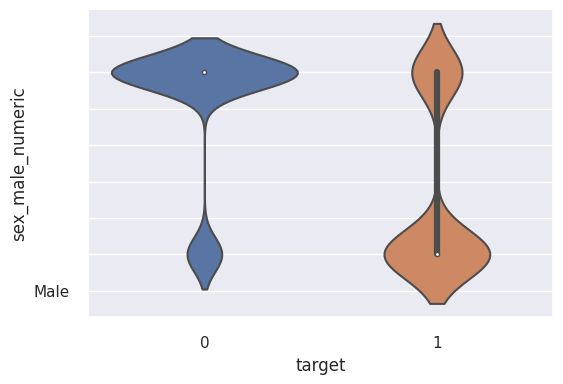

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))

new_df = X.copy()
new_df["target"] = y

new_df["sex_male_numeric"] = new_df["sex_male"].astype(int)

sns.violinplot(x="target", y="sex_male_numeric", data=new_df, ax=ax)

ax.set_yticklabels(["Female", "Male"])

plt.show()

## Comparando dois valores ordinais

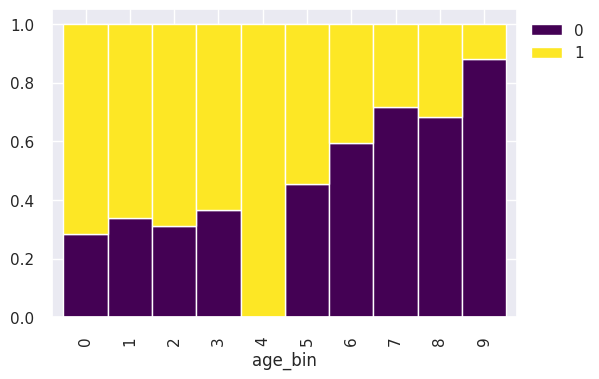

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))

X["age_bin"] = pd.qcut(X.age, q=10, labels=False)
X["class_bin"] = pd.qcut(X.pclass, q=3, labels=False, duplicates='drop')

data = (
    X.groupby(["age_bin", "class_bin"])
    .size()
    .unstack()
    .pipe(lambda df: df.div(df.sum(1), axis=0))
)

data.plot.bar(stacked=True, width=1, ax=ax, cmap="viridis")

ax.legend(bbox_to_anchor=(1, 1))

plt.show()


## Correlação

O `yellowbrick` é capaz de fazer comparações a pares entre os atributos, ao utilizar o método `rank2d()`.

Passando `algorithm='pearson'` como parâmetro, é possível utilizar a correlação de Pearson para fazer a comparação. Outros algorithmos podem ser utilizados, como o `covariance` e o `spearman`.

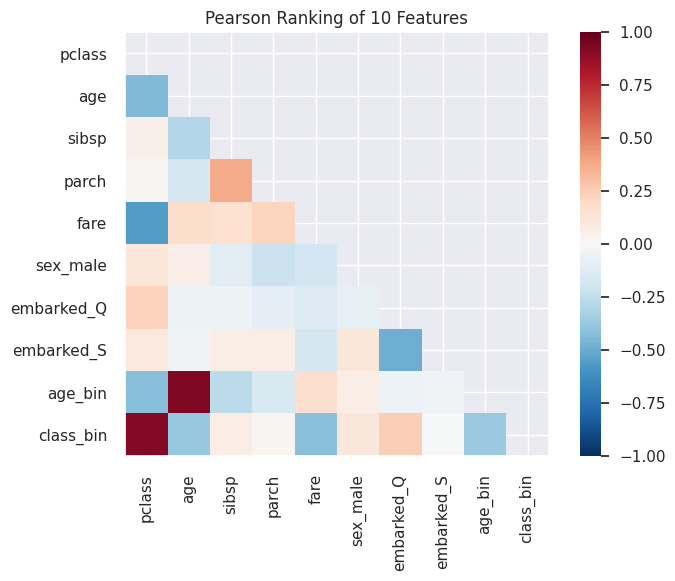

<Axes: title={'center': 'Pearson Ranking of 10 Features'}>

In [36]:
pcv = Rank2D(features=X.columns, algorithm="pearson")

pcv.fit(X, y)
pcv.transform(X)
pcv.show()

Um gráfico semelhane é possível de ser gerado com o `seaborn`, entretanto, ele não fornece a barra de cores por padrão é necessário setar `vmin` e `vmax`

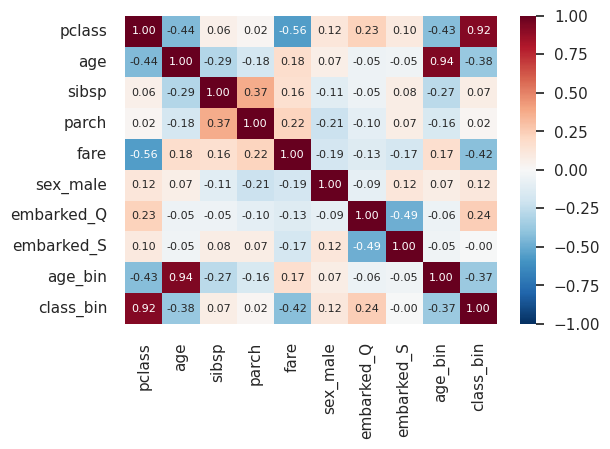

In [42]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.heatmap(
    X.corr(),
    fmt=".2f",
    ax=ax,
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    annot=True,
    annot_kws={"size":8}
)

Através do `pandas` é possível, exibir uma correlação entre as colunas. O método default é `pearson`, mas é possível definir o parâmetro `method` com `kendall`, `spearman` ou um callable que retorne ponto flutuante,

In [44]:
X.corr(method='kendall').iloc[:, :2]

,pclass,age
pclass,1.000000,-0.339676
age,-0.339676,1.000000
sibsp,-0.061628,-0.134374
parch,-0.026480,-0.184836
fare,-0.591686,0.101420
sex_male,0.118514,0.057263
embarked_Q,0.226739,-0.045198
embarked_S,0.067416,-0.034714
age_bin,-0.345932,0.955477
class_bin,0.908970,-0.315508


Colunas com alto grau de correlação não agregam e podem acarretar em prejuízos para a importância dos atributos e coeficientes de regressão

In [61]:
def correlated_columns(df, threshold=0.95):

    correlation_matrix = df.corr()

    lower_triangle = np.tril(correlation_matrix, k=-1)
    lower_triangle_df = pd.DataFrame(lower_triangle, columns=df.columns, index=df.columns)

    correlation_series = lower_triangle_df.stack().rename("pearson")

    correlated_pairs = correlation_series[abs(correlation_series) > threshold].reset_index()

    result_df = correlated_pairs.query("level_0 != level_1")

    return result_df

A função `correlated_clumns` verifica se existe alguma variavel com alto grau de correlação.

Vamos analisar etapa por etapa:

A função recebe o data frame e o nível de correlação como parâmetro, sendo que o data frame é obrigatório.

cria-se uma váriavel `correlation_matrix` que recebe uma matriz de correlação das variaveis do data frame.

Em sequência cria-se uma variavel `lower_triangle` que é o triangulo inferior da matriz de correlação. A função `np.tril` é interessante e deve ser comentada a parte:
  
  Considere uma seguinte variavel `matriz` =
$\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}$

Aplicando `np.tril(matriz, k=-1)` o retorno da função será o seguinte:

`retorno` = Matriz original:
$\begin{bmatrix}
0 & 0 & 0 \\
4 & 0 & 0 \\
7 & 8 & 0
\end{bmatrix}$

Ou seja acima da diagonal superior e a diagonal superior possuem seus valores zerados.

Tendo em vista o funcionamento da função `np.tril` é possível prosseguir.

Em sequência uma nova variavel é declarada `lower_triangle_df`, essa variavel basicamente um data frame com as diagonais.

Em sequência cria-se uma variavel `correlation_series`, essa variavel recebe um empilhamento do data frame `lower_triangle_df` e em sequência renomea-se a única coluna do data frame para `pearson`

E em sequência cria-se mais uma variavel `correlated_pairs` na qual está recebendo a seguinte expressão: Ele verifica inicialmente os valores afim de identificar quais valores possuem uma correlação maior que a estabelecida como parâmetro da função, criando assim uma máscara booleana, em sequência com o `reset_index` ocorre a conversão da mascara para a coluna normal dos valores.

A última variavel decretada `result_df` recebe uma consulta onde evita a coluna estar sendo relacionado consigo mesma

E por fim tem-se o retorno do `result_df`


In [63]:
data = {
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
}

df = pd.DataFrame(data)

stacked_df = df.stack().rename("Valor")

print(stacked_df.reset_index()["Valor"])

0    1
1    4
2    7
3    2
4    5
5    8
6    3
7    6
8    9
Name: Valor, dtype: int64


In [62]:
correlated_columns(X)

,level_0,level_1,pearson


In [67]:
agg =(
     org_df.groupby("cabin")
     .agg("min,max,mean,sum".split(",")) # funções de agregação
     .reset_index()
 )
agg.columns = [
     "_".join(c).strip("_")
     for c in agg.columns.values
 ]
agg_df = org_df.merge(agg, on="cabin")

<ipython-input-67-7832322a8542>:3: FutureWarning: ['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  .agg("min,max,mean,sum".split(","))


In [68]:
c_df = correlated_columns(agg_df.select_dtypes('number'))
c_df.style.format({"pearson": "{:.2f}"})

,level_0,level_1,pearson
0,pclass_min,pclass,1.00
1,pclass_max,pclass,1.00
2,pclass_max,pclass_min,1.00
3,pclass_mean,pclass,1.00
4,pclass_mean,pclass_min,1.00
5,pclass_mean,pclass_max,1.00
6,sibsp_mean,sibsp_max,0.97
7,parch_mean,parch_min,0.95
8,parch_mean,parch_max,0.96
9,fare_mean,fare,0.95


## Gráfico RadViz

Um gráfico RadViz exibe todas as amostras em um circulo, com atributos na circunferência. É uma técnica para visualizar o grau de separação entre os alvos.

É possível utilizar `RadViz` do `yellowbrick`para isso ou `usando o pandas`

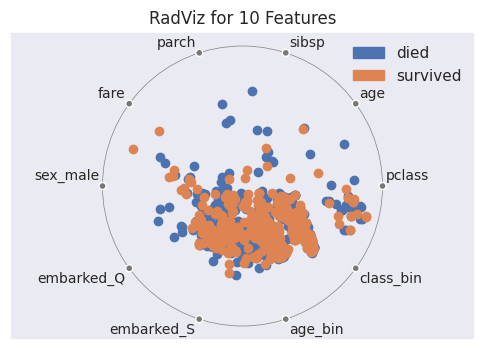

<Axes: title={'center': 'RadViz for 10 Features'}>

In [69]:
fig, ax = plt.subplots(figsize=(6,4))

rv = RadViz(
    classes=["died", "survived"],
    features= X.columns,
)

rv.fit(X,y)
_ = rv.transform(X)
rv.poof()

<Axes: >

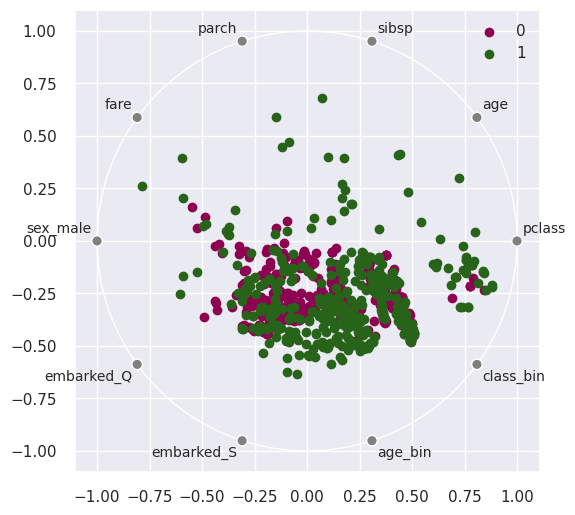

In [70]:
fig, ax = plt.subplots(figsize=(6,6))
new_df = X.copy()
new_df["target"] = y

pd.plotting.radviz(
    new_df,
    "target",
    ax=ax,
    colormap="PiYG"
)

## Coordenadas Paralelas

Utilizado para observar visualmente os agrupamentos.

Pode ser feito com `ParallelCoordinates` do `yellowbrick.features` ou `parallel_coordinates` do `pandas`

<ipython-input-71-92b901362e39>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


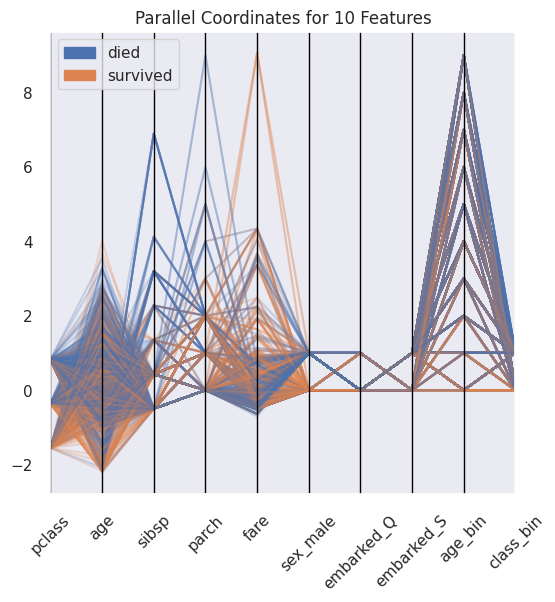

<Axes: title={'center': 'Parallel Coordinates for 10 Features'}>

In [71]:
fig, ax = plt.subplots(figsize=(6,6))
pc = ParallelCoordinates(
    classes=["died", "survived"],
    features = X.columns,
)

pc.fit(X, y)
pc.transform(X)

ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)
pc.poof()

[Text(0, 0, 'pclass'),
 Text(1, 0, 'age'),
 Text(2, 0, 'sibsp'),
 Text(3, 0, 'parch'),
 Text(4, 0, 'fare'),
 Text(5, 0, 'sex_male'),
 Text(6, 0, 'embarked_Q'),
 Text(7, 0, 'embarked_S'),
 Text(8, 0, 'age_bin'),
 Text(9, 0, 'class_bin')]

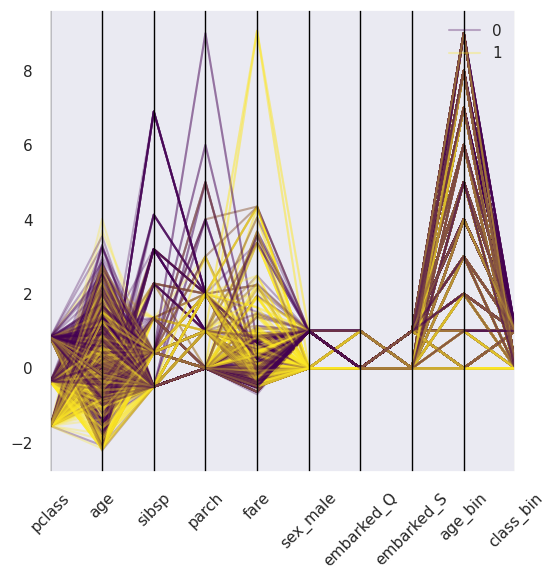

In [74]:
fig, ax = plt.subplots(figsize=(6,6))
new_df = X.copy()
new_df["target"] = y

pd.plotting.parallel_coordinates(
    new_df,
    "target",
    ax=ax,
    colormap="viridis",
    alpha=0.3
)

ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)